# Preprocessing

## JSON $\rightarrow$ Pandas
Turning metadatas json into useful and readable pandas dataframes

in order to make this script work you need to have the dataset in the working wolder such as:
```
>> fds-2022-final-project
    >> ...
    >> og_dataset
        >> slices.json
        >> splits
            >> train/
            >> dev/
            >> test/
```

In [1]:
import json
import os
import numpy as np
import pandas as pd

metadata_file = 'og_dataset/slices.geojson'
train_folder = 'og_dataset/splits/train/'
dev_folder   = 'og_dataset/splits/dev/'
test_folder  = 'og_dataset/splits/test/'

We first import the json file, and take only the information regarding all the patches, while adding to it the center of the longitude and latitude of the patch

In [2]:
with open(metadata_file) as f:
    d = json.load(f)
patches = d['features']
patches = [{
    **p['properties'], 
     'lng':np.mean(p['geometry']['coordinates'][0][:-1], axis=0)[0],
     'lat':np.mean(p['geometry']['coordinates'][0][:-1], axis=0)[1]
    } for p in patches]
patches[:2]

[{'img_source': '/datadrive/glaciers/unique_tiles/LE07_149037_20041024.tif',
  'mask_source': '/datadrive/glaciers/processed/masks/mask_00.npy',
  'img_slice': '/datadrive/glaciers/processed/slices/slice_0_img_000.npy',
  'mask_slice': '/datadrive/glaciers/processed/slices/slice_0_mask_000.npy',
  'mask_mean_0': 0.0,
  'mask_mean_1': 0.0,
  'mask_mean_2': 0.0,
  'img_mean': 77.38898468017578,
  'lng': 333795.9649122807,
  'lat': 3572176.06391926},
 {'img_source': '/datadrive/glaciers/unique_tiles/LE07_149037_20041024.tif',
  'mask_source': '/datadrive/glaciers/processed/masks/mask_00.npy',
  'img_slice': '/datadrive/glaciers/processed/slices/slice_0_img_001.npy',
  'mask_slice': '/datadrive/glaciers/processed/slices/slice_0_mask_001.npy',
  'mask_mean_0': 0.0,
  'mask_mean_1': 0.0,
  'mask_mean_2': 0.0,
  'img_mean': 133.6044158935547,
  'lng': 348977.8947368421,
  'lat': 3572176.06391926}]

Now we port the dataset into pandas and clean it, by:
- taking the number of the original img it came from
- taking the slice number
- using the 2 aforemwntioned features as index
- drop the name of the original file it came from
- combine (sum) the mean of layer 0 and 1 of the mask together
- drop the mean of layer 0 and 1 of the mask (since those are now combined in `mask_mean`)
- rename the `mask_mean_2` as `china`, since it's the percentage of china represented in the image

In [3]:
metadata = pd.DataFrame(patches)
files_columns = ['img_source','mask_source','img_slice','mask_slice']
metadata[files_columns] = metadata[files_columns].applymap(lambda x: x.split('/')[-1])
metadata['src'] = metadata.img_slice.map(lambda s: s.split('_')[1])
metadata['slice_num'] = metadata.img_slice.map(lambda s: s.split('_')[-1][:3])
metadata.set_index(['src', 'slice_num'], inplace=True)
metadata.drop(columns=['img_source', 'mask_source'], inplace=True)
metadata.rename(columns={'mask_mean_0':'glaciers', 'mask_mean_1':'clean_glaciers','mask_mean_2':'debris_glaciers'}, inplace=True)

metadata.head()

img_slice            mask_slice  glaciers  \
src slice_num                                                        
0   000        slice_0_img_000.npy  slice_0_mask_000.npy       0.0   
    001        slice_0_img_001.npy  slice_0_mask_001.npy       0.0   
    002        slice_0_img_002.npy  slice_0_mask_002.npy       0.0   
    003        slice_0_img_003.npy  slice_0_mask_003.npy       0.0   
    004        slice_0_img_004.npy  slice_0_mask_004.npy       0.0   

               clean_glaciers  debris_glaciers    img_mean            lng  \
src slice_num                                                               
0   000                   0.0              0.0   77.388985  333795.964912   
    001                   0.0              0.0  133.604416  348977.894737   
    002                   0.0              0.0   94.324028  364159.824561   
    003                   0.0              0.0  189.766983  379341.754386   
    004                   0.0              0.0  198.229507  394523.684211   

                        lat  
src slice_num                
0   000        3.572176e+06  
    001        3.572176e+06  
    002        3.572176e+06  
    003        3.572176e+06  
    004        3.572176e+06

Then we take the list of all the slice files for each folder

In [4]:
def list_files(folder):
    list_of_files = []

    for root, dirs, files in os.walk(folder):
        for file in files:
            list_of_files.append(file)
    return list_of_files

train_splits = list_files(train_folder)
dev_splits = list_files(dev_folder)
test_splits = list_files(test_folder)

dev_splits[:3]

['slice_28_mask_182.npy', 'slice_22_mask_156.npy', 'slice_23_mask_194.npy']

And finally we partition the metadata in 3 different datasets

In [5]:
def partition_metadata(metadata, folder = '', name = ''):
    files = list_files(folder)
    partition = metadata.img_slice.isin( files )
    # takes only the rows corresponding to those in the splits
    metadata.loc[partition, 'partition'] = name
    # then prefix the file with the folder
    metadata.loc[partition, 'img_slice'] = folder + metadata.loc[partition, 'img_slice']
    metadata.loc[partition, 'mask_slice'] = folder + metadata.loc[partition, 'mask_slice']
    return metadata

metadata = partition_metadata(metadata, folder=dev_folder, name='dev')
metadata = partition_metadata(metadata, folder=test_folder, name='test')
metadata = partition_metadata(metadata, folder=train_folder, name='train')


metadata.head()

img_slice  \
src slice_num                                                
0   000                                slice_0_img_000.npy   
    001                                slice_0_img_001.npy   
    002                                slice_0_img_002.npy   
    003        og_dataset/splits/train/slice_0_img_003.npy   
    004        og_dataset/splits/train/slice_0_img_004.npy   

                                                 mask_slice  glaciers  \
src slice_num                                                           
0   000                                slice_0_mask_000.npy       0.0   
    001                                slice_0_mask_001.npy       0.0   
    002                                slice_0_mask_002.npy       0.0   
    003        og_dataset/splits/train/slice_0_mask_003.npy       0.0   
    004        og_dataset/splits/train/slice_0_mask_004.npy       0.0   

               clean_glaciers  debris_glaciers    img_mean            lng  \
src slice_num                                                               
0   000                   0.0              0.0   77.388985  333795.964912   
    001                   0.0              0.0  133.604416  348977.894737   
    002                   0.0              0.0   94.324028  364159.824561   
    003                   0.0              0.0  189.766983  379341.754386   
    004                   0.0              0.0  198.229507  394523.684211   

                        lat partition  
src slice_num                          
0   000        3.572176e+06       NaN  
    001        3.572176e+06       NaN  
    002        3.572176e+06       NaN  
    003        3.572176e+06     train  
    004        3.572176e+06     train

In [6]:
metadata.dropna(inplace=True) # we remove those pathces that are not in any of the 3 partitions
metadata.to_csv('dataset/metadata.csv')

Now, to load a dataset you just need to run:
```python
pd.read_csv('dataset/metadata.csv', index_col=['src','slice_num']).head()
```

## Extract infos from metadata
We now want to get some informations out of the JSONs we just worked with

### Glaciers percentages

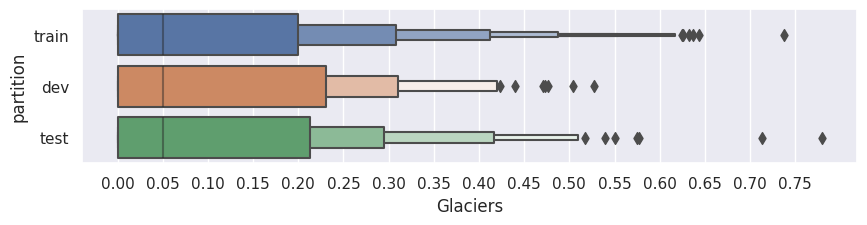

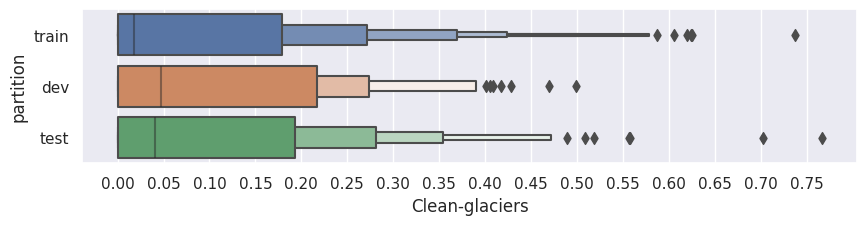

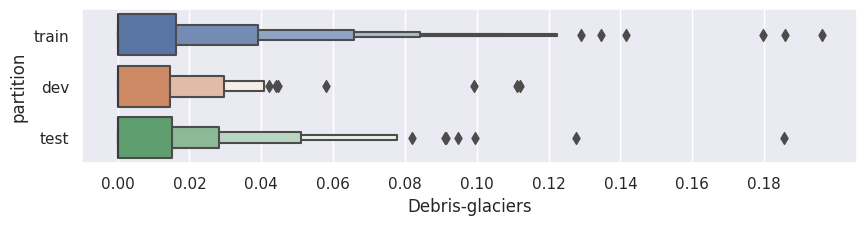

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')
sns.set(rc={"figure.figsize":(10, 2)})

sns.boxenplot(data=metadata, x='glaciers', y='partition')
plt.xticks(np.arange(0,metadata.glaciers.max(), .05))
plt.xlabel('Glaciers')
plt.show()

sns.boxenplot(data=metadata, x='clean_glaciers', y='partition')
plt.xticks(np.arange(0,metadata.clean_glaciers.max(), .05))
plt.xlabel('Clean-glaciers')
plt.show()

sns.boxenplot(data=metadata, x='debris_glaciers', y='partition')
plt.xticks(np.arange(0,metadata.debris_glaciers.max(), .02))
plt.xlabel('Debris-glaciers')
plt.show()

## **This part is now useless**, To be removed; Create new Masks

We now want to read all the masks, which are $512 \times 512 \times 3$ `np.array` and we want to sum just the first 2 layers between themselves, as the layers of the array represent:
1. Clean-ice Glacier
2. Debris covered glacier
3. Is in china

We first load each matrix, but it appears some of the files are corrupted:

In [8]:
def load(file):
    try:
        return np.load(file)
    except:
        return pd.NA
    
# metadata['np_mask'] = metadata.mask_slice.apply(lambda x: load(x))

In [22]:
metadata.np_mask.isna().sum()

0

Then we get the percentage of HKH in the patch, this differs from china for some reason

In [10]:
metadata['debris_mean'] = metadata.np_mask.map(lambda m: m[:,:,1].mean(), na_action='ignore')

Then we combine together the first 2 layers of the masks:

In [11]:
metadata['clean_mean'] = metadata.np_mask.map(lambda m: m[:,:,0].mean(), na_action='ignore')

Finally we compute the mean of each of the masks:

In [12]:
metadata['glacier_perc'] = metadata.np_mask.map(lambda m: 1 - m[:,:,2].mean(), na_action='ignore')
train_data.head()

img_slice  \
src slice_num                                                
0   010        og_dataset/splits/train/slice_0_img_010.npy   
    033        og_dataset/splits/train/slice_0_img_033.npy   
    034        og_dataset/splits/train/slice_0_img_034.npy   
    041        og_dataset/splits/train/slice_0_img_041.npy   
    119        og_dataset/splits/train/slice_0_img_119.npy   

                                                 mask_slice  mask_mean_0  \
src slice_num                                                              
0   010        og_dataset/splits/train/slice_0_mask_010.npy          0.0   
    033        og_dataset/splits/train/slice_0_mask_033.npy          0.0   
    034        og_dataset/splits/train/slice_0_mask_034.npy          0.0   
    041        og_dataset/splits/train/slice_0_mask_041.npy          0.0   
    119        og_dataset/splits/train/slice_0_mask_119.npy          0.0   

               mask_mean_1  mask_mean_2    img_mean            lng  \
src slice_num                                                        
0   010                0.0          0.0  113.734550  485615.263158   
    033                0.0          0.0  190.532776  379341.754386   
    034                0.0          0.0  196.605057  394523.684211   
    041                0.0          0.0  203.208298  500797.192982   
    119                0.0          0.0  126.572365  546342.982456   

                        lat  \
src slice_num                 
0   010        3.572176e+06   
    033        3.602540e+06   
    034        3.602540e+06   
    041        3.602540e+06   
    119        3.678451e+06   

                                                         np_mask  debris_mean  \
src slice_num                                                                   
0   010        [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...          0.0   
    033        [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...          0.0   
    034        [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...          0.0   
    041        [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...          0.0   
    119        [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...          0.0   

               clean_mean  glacier_perc  
src slice_num                            
0   010               0.0           1.0  
    033               0.0           1.0  
    034               0.0           1.0  
    041               0.0           1.0  
    119               0.0           1.0

We notice that strangely the debris_mean and the clean_mean _almost_ add up to 1

### Glaciers percentage
Finally we can see the distribution of percentages of glaciers

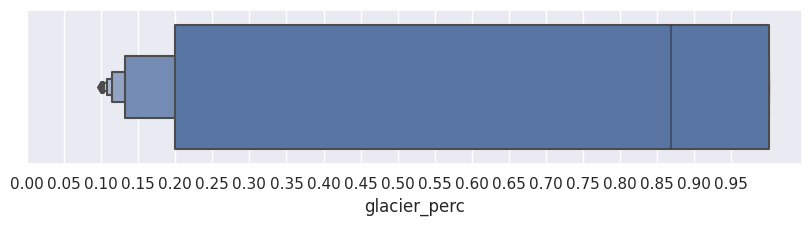

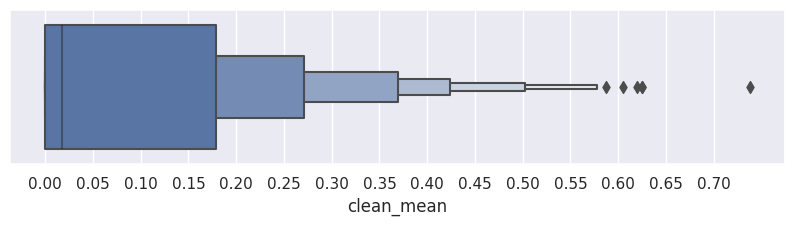

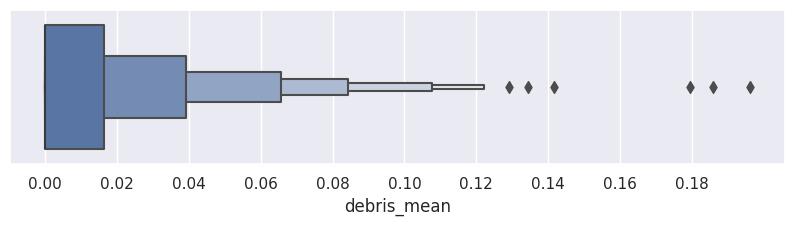

In [13]:
sns.boxenplot(data=train_data.dropna(), x='glacier_perc' )
plt.xticks(np.arange(0,train_data.glacier_perc.max(),0.05))
plt.show()

sns.boxenplot(data=train_data.dropna(), x='clean_mean' )
plt.xticks(np.arange(0,train_data.clean_mean.max(),0.05))
plt.show()

sns.boxenplot(data=train_data.dropna(), x='debris_mean' )
plt.xticks(np.arange(0,train_data.debris_mean.max(),0.02))
plt.show()

Aside from the data being a little strange since they are sometimes bigger than 1, I would say that the optimal choice for the **threshold** should be $0.2$.

In [14]:
## Save the new np masks, unnecesary
# metadata\
#     .reset_index()\
#     .apply(lambda r: 
#             np.save(f'dataset/masks/dev/slice_{r.src}_mask_{r.slice_num}.npy', r.np_mask),
#            axis=1)
# ;

### Creating Label for images based on our threshold value of 0.2 and Masks of the image.

> Those images with pixels less than 20% are identified as non-glacier image and more than 20% as glacier image

In [15]:
THRESHOLD = 0.2
metadata['label'] = metadata.glacier_perc.map(lambda x: 1 if x > THRESHOLD else 0, na_action='ignore')
metadata.head()

img_slice  \
src slice_num                                                
0   010        og_dataset/splits/train/slice_0_img_010.npy   
    033        og_dataset/splits/train/slice_0_img_033.npy   
    034        og_dataset/splits/train/slice_0_img_034.npy   
    041        og_dataset/splits/train/slice_0_img_041.npy   
    119        og_dataset/splits/train/slice_0_img_119.npy   

                                                 mask_slice  mask_mean_0  \
src slice_num                                                              
0   010        og_dataset/splits/train/slice_0_mask_010.npy          0.0   
    033        og_dataset/splits/train/slice_0_mask_033.npy          0.0   
    034        og_dataset/splits/train/slice_0_mask_034.npy          0.0   
    041        og_dataset/splits/train/slice_0_mask_041.npy          0.0   
    119        og_dataset/splits/train/slice_0_mask_119.npy          0.0   

               mask_mean_1  mask_mean_2    img_mean            lng  \
src slice_num                                                        
0   010                0.0          0.0  113.734550  485615.263158   
    033                0.0          0.0  190.532776  379341.754386   
    034                0.0          0.0  196.605057  394523.684211   
    041                0.0          0.0  203.208298  500797.192982   
    119                0.0          0.0  126.572365  546342.982456   

                        lat  \
src slice_num                 
0   010        3.572176e+06   
    033        3.602540e+06   
    034        3.602540e+06   
    041        3.602540e+06   
    119        3.678451e+06   

                                                         np_mask  debris_mean  \
src slice_num                                                                   
0   010        [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...          0.0   
    033        [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...          0.0   
    034        [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...          0.0   
    041        [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...          0.0   
    119        [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...          0.0   

               clean_mean  glacier_perc  label  
src slice_num                                   
0   010               0.0           1.0      1  
    033               0.0           1.0      1  
    034               0.0           1.0      1  
    041               0.0           1.0      1  
    119               0.0           1.0      1

### Checking Counts for different classes for each set

In [16]:
metadata[metadata.partition == 'train'].label.value_counts()

1    575
0    191
Name: label, dtype: int64

#### We see that choosing threshold of  *20%* of number of pixels identified as snow gives us a balanced training dataset

In [17]:
metadata[metadata.partition == 'test'].label.value_counts()

1    173
0     47
Name: label, dtype: int64

In [18]:
metadata[metadata.partition == 'dev'].label.value_counts()

1    89
0    21
Name: label, dtype: int64

#### Validation set also seems to be more or less balanced (60%,40% split between the two class)

In [19]:
metadata.to_csv('dataset/metadata.csv')

## Distributions of features and binning
We now want to get a feel of what's the distribution of values of the 15 channels:
1. LE7 B1 (blue)
2. LE7 B2 (green)
3. LE7 B3 (red)
4. LE7 B4 (near infrared)
5. LE7 B5 (shortwave infrared 1)
6. LE7 B6_VCID_1 (low-gain thermal infrared)
7. LE7 B6_VCID_2 (high-gain thermal infrared)
8. LE7 B7 (shortwave infrared 2)
9. LE7 B8 (panchromatic)
10. LE7 BQA (quality bitmask)
11. NDVI (vegetation index)
12. NDSI (snow index)
13. NDWI (water index)
14. SRTM 90 elevation
15. SRTM 90 slope

In [9]:
np.histogram(np.load(test_folder + 'slice_10_img_174.npy')[:,:,2], density=True)
# np.load(train_folder + 'slice_1_img_150.npy')
# https://numpy.org/doc/stable/reference/generated/numpy.histogram.html

(array([0.25991968, 0.52085916, 0.25687425, 0.17556859, 0.17742167,
        0.18223393, 0.19781991, 0.23406269, 0.26239046, 1.49853848]),
 array([-1.4382831 , -1.1727275 , -0.9071718 , -0.6416161 , -0.37606046,
        -0.11050481,  0.15505084,  0.4206065 ,  0.6861622 ,  0.9517178 ,
         1.2172735 ], dtype=float32))

Load the images from the _dev set_ to memory to perform analysis on the distribution of values. We pick only those in _dev set_ due to memory limitations

In [10]:
metadata.loc[metadata.partition=='dev','features'] = metadata[metadata.partition=='dev'].img_slice.apply(lambda x: np.load(x))
dev_data = metadata[metadata.partition=='dev']

dev_data.features.iloc[0][:,:,1]

array([[49., 49., 48., ..., 68., 60., 59.],
       [49., 48., 48., ..., 79., 64., 65.],
       [49., 46., 47., ..., 68., 64., 67.],
       ...,
       [69., 69., 67., ..., 62., 61., 60.],
       [67., 70., 69., ..., 62., 62., 64.],
       [67., 68., 67., ..., 63., 62., 60.]], dtype=float32)

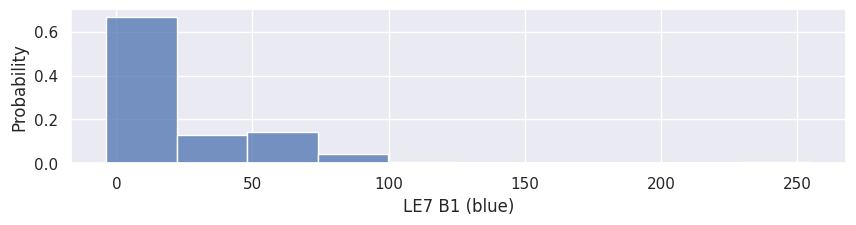

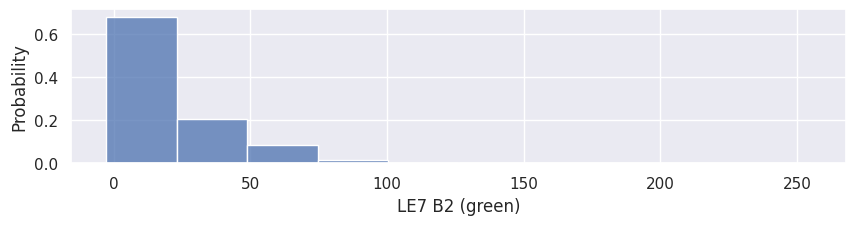

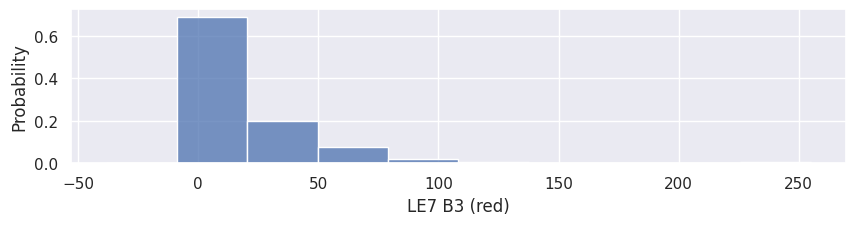

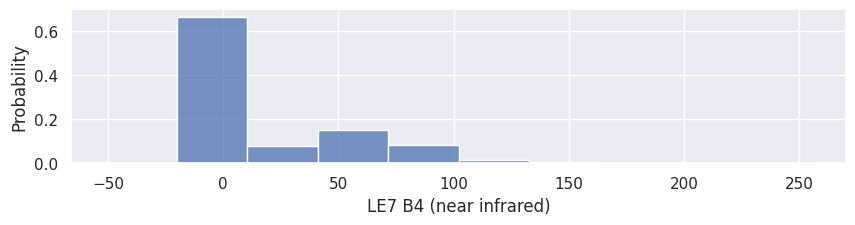

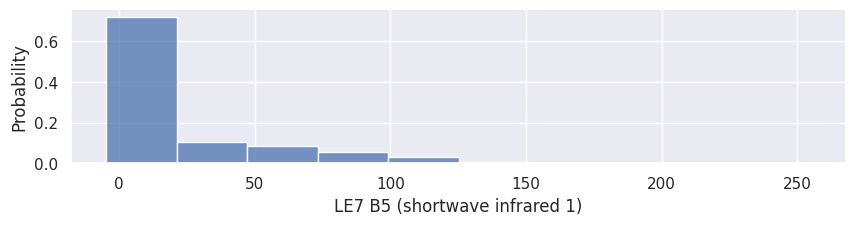

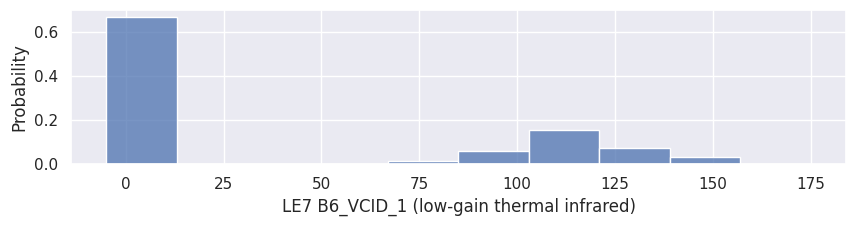

In [ ]:
descr = pd.DataFrame() 

feature_names = ['LE7 B1 (blue)', 'LE7 B2 (green)', 'LE7 B3 (red)', 'LE7 B4 (near infrared)', 'LE7 B5 (shortwave infrared 1)', 'LE7 B6_VCID_1 (low-gain thermal infrared)', 'LE7 B6_VCID_2 (high-gain thermal infrared)', 'LE7 B7 (shortwave infrared 2)', 'LE7 B8 (panchromatic)', 'LE7 BQA (quality bitmask)', 'NDVI (vegetation index)', 'NDSI (snow index)', 'NDWI (water index)', 'SRTM 90 elevation', 'SRTM 90 slope']
for i,name in enumerate(feature_names):
    d_i = dev_data.features.apply(lambda m: m[:,:,i].flat).agg(np.concatenate)
    d_i = d_i[np.logical_not(np.isnan(d_i))]
    p01 = np.percentile(d_i, 1e-4)
    p99 = np.percentile(d_i, 1 - 1e-4)
    # print(p01, p99)
    # d_i = d_i[(d_i>=-10) & (d_i<=10)]
    
    descr = pd.concat([
        descr, 
        pd.Series(d_i, name=name).agg([min, 'median', 'mean', max])
    ], axis=1)
    
    sns.histplot(x=d_i, stat='probability', bins=10)
    del d_i
    plt.xlabel(name)
    plt.show()

It appears that there are some extreme outliers:
May be caused by the corrupted files in my harddisk?

In [ ]:
BIN_SIZE = 0.5

descr = descr.transpose()
descr['layer'] = range(0,15)
descr['bins'] = descr.apply(lambda x: np.arange(x['min'], x['max'], BIN_SIZE), axis=1)
descr

In [ ]:
histos = pd.DataFrame()
for i, name in enumerate(feature_names):
    histos[name] = metadata.features.apply(
        lambda m, bins: np.histogram(m[:,:,i], bins=bins, density=True)[0], 
        args=(descr.bins.to_list()[i],))
    
histos.head()